In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from skbio import OrdinationResults
from biom import load_table
from matplotlib_venn import venn2

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Define functions

In [2]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

## Load data

In [3]:
#load rpca results
ord_18S = OrdinationResults.read('../results/joint-rpca/18S_ord.txt')
ord_mag = OrdinationResults.read('../results/joint-rpca/mag_ord.txt')
ord_gene = OrdinationResults.read('../results/joint-rpca/gene_ord.txt')
ord_gene_module = OrdinationResults.read('../results/joint-rpca/gene_module_ord.txt')
ord_metabolite = OrdinationResults.read('../results/joint-rpca/metabolite_ord.txt')
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord.txt')
#load shared metadata
metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [4]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [5]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


## Find overlapping features

In [6]:
pc_ratio = {}

for task in ['facility', 'stage', 'season']:
    acc_task = pd.DataFrame(columns=['Omic', 'Fold', 'Accuracy',
                                     'Report', 'Optimization', 'PC'])
    for pc in ['PC1','PC2','PC3']:
        #load results
        #acc_ratio = pd.read_csv('../results/joint-rpca/RF/rf_acc_{}-ratio_{}_opt.csv'.format(pc, task))
        acc_ratio = pd.read_csv('../results/joint-rpca/KNN/knn_acc_{}-ratio_{}.tsv'.format(pc, task),
                                sep='\t', index_col=0)
        #add PC column
        acc_ratio['PC'] = pc
        #save results
        acc_task = acc_task._append(acc_ratio, ignore_index=True)
    
    pc_ratio[task] = acc_task

In [10]:
best_pc_per_task = {}

for task in ['facility', 'stage', 'season']:
    #Find the median accuracy across folds for each modality and PC
    median_values = pc_ratio[task].groupby(['Omic', 'PC']).median(numeric_only=True)
    median_values = median_values.reset_index()

    #Find the PC with the maximum value for each Omic
    max_pc_per_omic = median_values.loc[median_values.groupby('Omic')['Accuracy'].idxmax()]

    #Store results in dictionary
    result_dict = max_pc_per_omic.set_index('Omic').apply(tuple, axis=1).to_dict()
    best_pc_per_task[task] = result_dict

In [21]:
#define parameters
quantile = 0.90
task = 'season' #'season', 'facility'
groups = ['fall', 'spring', 'summer', 'winter'] #for season
#groups = ['FIRS', 'STAFS', 'ARF'] #for facility
best_pc = best_pc_per_task[task]
best_pc

{'18S_Joint-RPCA': ('PC2', 0.48808848553601814),
 '18S_RPCA': ('PC2', 0.44351134079816246),
 'Gene_Joint-RPCA': ('PC1', 0.44680851063829785),
 'Gene_Module_Joint-RPCA': ('PC1', 0.4032146160962071),
 'Gene_Module_RPCA': ('PC1', 0.35827041866849696),
 'Gene_RPCA': ('PC3', 0.4042553191489361),
 'MAG_Joint-RPCA': ('PC2', 0.4402103273071014),
 'MAG_RPCA': ('PC2', 0.45744680851063824),
 'Metabolite_Joint-RPCA': ('PC3', 0.42021276595744683),
 'Metabolite_RPCA': ('PC3', 0.4308510638297872)}

In [24]:
#find top/bottom features from individual RPCA results
rpca_ord = {'18S_RPCA': ord_18S, 'MAG_RPCA': ord_mag, 'Gene_RPCA': ord_gene, 
            'Gene_Module_RPCA': ord_gene_module, 'Metabolite_RPCA': ord_metabolite}

rpca_top_fts = {}
rpca_bot_fts = {}

for omic_pc, omic_table in zip(rpca_ord.keys(), tables.keys()):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc[omic_pc][0]
    ord_ = rpca_ord[omic_pc].features.copy()
    table_ = tables[omic_table]
    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    rpca_top_fts[omic_pc] = top_fts
    rpca_bot_fts[omic_pc] = bottom_fts

18S 18S_RPCA
mag MAG_RPCA
gene Gene_RPCA
gene_module Gene_Module_RPCA
metabolite Metabolite_RPCA


In [38]:
#find top features from joint-RPCA results
joint_pc_ids = ['{}_Joint-RPCA'.format(id.split('_')[0]) if 'Module' not in id else 'Gene_Module_Joint-RPCA'
                for id in rpca_ord.keys()]
joint_top_fts = {}
joint_bot_fts = {}

for omic_pc, omic_table in zip(joint_pc_ids, tables.keys()):
    #sanity check
    print(omic_table, omic_pc)
    pc_to_use = best_pc[omic_pc][0]
    table_ = tables[omic_table]
    if omic_table == '18S':
        ord_ = joint_features.loc[in_ord_18S]
    else:
        ord_ = joint_features.loc[table_.ids(axis='observation')]

    _, _, _, top_fts, bottom_fts = get_top_features(table_, ord_, component=pc_to_use,
                                                    quantile=quantile, pseudocount=0)
    joint_top_fts[omic_pc] = top_fts
    joint_bot_fts[omic_pc] = bottom_fts

18S 18S_Joint-RPCA
mag MAG_Joint-RPCA
gene Gene_Joint-RPCA
gene_module Gene_Module_Joint-RPCA
metabolite Metabolite_Joint-RPCA


In [59]:
#RCPA TOP and Joint-RPCA TOP intersecting features
common_top_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_top_fts[omic_rpca]).intersection(joint_top_fts[omic_joint])
    common_top_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_top_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 14
Total features: 26. Number of intersecting features for mag: 4
Total features: 246. Number of intersecting features for gene: 20
Total features: 38. Number of intersecting features for gene_module: 13
Total features: 234. Number of intersecting features for metabolite: 63


In [60]:
#RCPA TOP and Joint-RPCA BOTTOM intersecting features
common_top_fts2 = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_top_fts[omic_rpca]).intersection(joint_bot_fts[omic_joint])
    common_top_fts2[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_top_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 292
Total features: 26. Number of intersecting features for mag: 0
Total features: 246. Number of intersecting features for gene: 90
Total features: 38. Number of intersecting features for gene_module: 5
Total features: 234. Number of intersecting features for metabolite: 19


In [61]:
#RCPA BOTTOM and Joint-RPCA BOTTOM intersecting features
common_bottom_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_bot_fts[omic_rpca]).intersection(joint_bot_fts[omic_joint])
    common_bottom_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_bot_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 39
Total features: 26. Number of intersecting features for mag: 21
Total features: 246. Number of intersecting features for gene: 15
Total features: 38. Number of intersecting features for gene_module: 0
Total features: 234. Number of intersecting features for metabolite: 70


In [62]:
#RCPA BOTTOM and Joint-RPCA TOP intersecting features
common_bottom_fts2 = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    common_fts = set(rpca_bot_fts[omic_rpca]).intersection(joint_top_fts[omic_joint])
    common_bottom_fts2[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(joint_bot_fts[omic_joint]), omic_id, len(common_fts)))

Total features: 544. Number of intersecting features for 18S: 249
Total features: 26. Number of intersecting features for mag: 0
Total features: 246. Number of intersecting features for gene: 97
Total features: 38. Number of intersecting features for gene_module: 1
Total features: 234. Number of intersecting features for metabolite: 6


In [54]:
#find intersecting bottom features
common_top_bot_fts = {}
for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
    common_fts = set(rpca_top_bot).intersection(joint_top_bot)
    common_top_bot_fts[omic_id] = common_fts
    print("Total features: %i. Number of intersecting features for %s: %i" % (len(rpca_top_bot), omic_id, len(common_fts)))

Total features: 1087. Number of intersecting features for 18S: 594
Total features: 52. Number of intersecting features for mag: 25
Total features: 492. Number of intersecting features for gene: 222
Total features: 76. Number of intersecting features for gene_module: 19
Total features: 468. Number of intersecting features for metabolite: 158


## Plotting

In [74]:
#find the average ranks of the intersecting features
avg_ranks_common_top = {}
avg_ranks_common_bottom = {}

for omic_rpca, omic_joint, omic_id in zip(rpca_ord.keys(), joint_pc_ids, tables.keys()):
    top_ranks_rpca = []
    top_ranks_joint = []

    bottom_ranks_rpca = []
    bottom_ranks_joint = []

    for ft in common_top_bot_fts[omic_id]:

        #check rank in rpca
        if ft in rpca_top_fts[omic_rpca]:
            r_rpca = rpca_top_fts[omic_rpca].index(ft) + 1
            top_ranks_rpca.append(r_rpca)
        elif ft in rpca_bot_fts[omic_rpca]:
            r_rpca = rpca_bot_fts[omic_rpca].index(ft) + 1
            bottom_ranks_rpca.append(r_rpca)

        #check rank in joint-rpca
        if ft in joint_top_fts[omic_joint]:
            r_joint = joint_top_fts[omic_joint].index(ft) + 1
            top_ranks_joint.append(r_rpca)
        elif ft in joint_bot_fts[omic_joint]:
            r_joint = joint_bot_fts[omic_joint].index(ft) + 1
            bottom_ranks_joint.append(r_rpca)
        
    avg_ranks_common_top[omic_id] = (np.mean(top_ranks_rpca), 
                              np.mean(top_ranks_joint))
    avg_ranks_common_bottom[omic_id] = (np.mean(bottom_ranks_rpca), 
                                 np.mean(bottom_ranks_joint))

In [75]:
avg_ranks_common_top

{'18S': (233.23529411764707, 283.68441064638785),
 'mag': (16.5, 16.5),
 'gene': (105.77272727272727, 133.42735042735043),
 'gene_module': (19.11111111111111, 21.214285714285715),
 'metabolite': (119.58536585365853, 109.04347826086956)}

In [76]:
avg_ranks_common_bottom

{'18S': (294.43402777777777, 246.3987915407855),
 'mag': (15.428571428571429, 15.428571428571429),
 'gene': (136.375, 107.6),
 'gene_module': (37.0, 16.8),
 'metabolite': (160.51315789473685, 162.7078651685393)}

In [80]:
avg_ranks_top_rpca_only = {}
avg_ranks_bottom_rpca_only = {}

for omic_rpca, omic_id in zip(rpca_ord.keys(), tables.keys()):
    ranks_top_rpca_only = []
    ranks_bot_rpca_only = []

    #get features unique to RPCA 
    rpca_only_top = set(rpca_top_fts[omic_rpca]) - set(common_top_bot_fts[omic_id])
    rpca_only_bot = set(rpca_bot_fts[omic_rpca]) - set(common_top_bot_fts[omic_id])
    print("Number of features unique to RPCA for %s: %i" % (omic_id, len(rpca_only_top)+len(rpca_only_bot)))
    for ft in rpca_only_top:
        r_rpca = rpca_top_fts[omic_rpca].index(ft) + 1
        ranks_top_rpca_only.append(r_rpca)
    
    for ft in rpca_only_bot:
        r_rpca = rpca_bot_fts[omic_rpca].index(ft) + 1
        ranks_bot_rpca_only.append(r_rpca)
        
    avg_ranks_top_rpca_only[omic_id] = np.mean(ranks_top_rpca_only)
    avg_ranks_bottom_rpca_only[omic_id] = np.mean(ranks_bot_rpca_only)

Number of features unique to RPCA for 18S: 493
Number of features unique to RPCA for mag: 27
Number of features unique to RPCA for gene: 270
Number of features unique to RPCA for gene_module: 57
Number of features unique to RPCA for metabolite: 310


In [92]:
avg_ranks_top_joint_only = {}
avg_ranks_bottom_joint_only = {}

for omic_joint, omic_id in zip(joint_pc_ids, tables.keys()):
    ranks_top_joint_only = []
    ranks_bot_joint_only = []

    #get features unique to RPCA 
    joint_only_top = set(joint_top_fts[omic_joint]) - set(common_top_bot_fts[omic_id])
    joint_only_bot = set(joint_bot_fts[omic_joint]) - set(common_top_bot_fts[omic_id])
    print("Number of features unique to Joint-RPCA for %s: %i" % (omic_id, len(joint_only_top)+len(joint_only_bot)))
    for ft in joint_only_top:
        r_joint = joint_top_fts[omic_joint].index(ft) + 1
        ranks_top_joint_only.append(r_joint)
    
    for ft in joint_only_bot:
        r_joint = joint_bot_fts[omic_joint].index(ft) + 1
        ranks_bot_joint_only.append(r_joint)
        
    avg_ranks_top_joint_only[omic_id] = np.mean(ranks_top_joint_only)
    avg_ranks_bottom_joint_only[omic_id] = np.mean(ranks_bot_joint_only)

Number of features unique to Joint-RPCA for 18S: 494
Number of features unique to Joint-RPCA for mag: 27
Number of features unique to Joint-RPCA for gene: 270
Number of features unique to Joint-RPCA for gene_module: 57
Number of features unique to Joint-RPCA for metabolite: 310


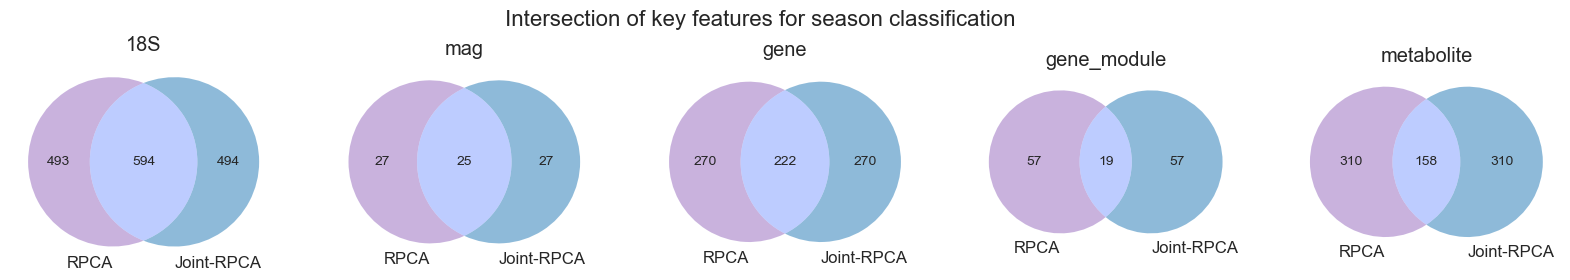

In [90]:
#plot a venn diagram per omic
fig, axn = plt.subplots(1, 5, figsize=(20, 5))
for ax_, omic_id, omic_rpca, omic_joint in zip(axn.flatten(), tables.keys(),
                                               rpca_ord.keys(), joint_pc_ids):
    
    rpca_top_bot = set(rpca_top_fts[omic_rpca]).union(set(rpca_bot_fts[omic_rpca]))
    joint_top_bot = set(joint_top_fts[omic_joint]).union(set(joint_bot_fts[omic_joint]))
                                                         
    a = len(rpca_top_bot) - len(common_top_bot_fts[omic_id])
    b = len(common_top_bot_fts[omic_id])
    c = len(joint_top_bot) - len(common_top_bot_fts[omic_id])

    venn2(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
          set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
    ax_.set_title(omic_id)
    plt.suptitle('Intersection of key features for {} classification'.format(task), 
                 fontsize=16, y=0.8)
#plt.tight_layout()
plt.show()

In [104]:
#create table with top and bottom ranks
#Common features: avg_ranks_common_top, avg_ranks_common_bottom
#RPCA only: avg_ranks_top_rpca_only, avg_ranks_bottom_rpca_only
#Joint-RPCA only: avg_ranks_top_joint_only, avg_ranks_bottom_joint_only

#top ranks
top_ranks = pd.DataFrame(columns=['Omic', 'RPCA', 'Common', 'Joint-RPCA'])
for omic_id in tables.keys():
    top_ranks = top_ranks._append({'Omic': omic_id, 
                                   'RPCA': round(avg_ranks_top_rpca_only[omic_id], 2),
                                   'Common': round(avg_ranks_common_top[omic_id][0], 2),
                                   'Joint-RPCA': round(avg_ranks_top_joint_only[omic_id], 2)}, 
                                   ignore_index=True)
top_ranks.set_index('Omic', inplace=True)

#bottom ranks
bottom_ranks = pd.DataFrame(columns=['Omic', 'RPCA', 'Common', 'Joint-RPCA'])
for omic_id in tables.keys():
    bottom_ranks = bottom_ranks._append({'Omic': omic_id, 
                                         'RPCA': round(avg_ranks_bottom_rpca_only[omic_id], 2),
                                         'Common': round(avg_ranks_common_bottom[omic_id][0], 2),
                                         'Joint-RPCA': round(avg_ranks_bottom_joint_only[omic_id], 2)}, 
                                         ignore_index=True)
bottom_ranks.set_index('Omic', inplace=True)


In [105]:
print("Ranks of top features:")
display(top_ranks.T)
print()
print("Ranks of bottom features:")
display(bottom_ranks.T)

Ranks of top features:


Omic,18S,mag,gene,gene_module,metabolite
RPCA,322.98,12.95,137.84,19.85,116.38
Common,233.24,16.50,105.77,19.11,119.59
Joint-RPCA,333.21,12.77,139.79,21.96,123.20



Ranks of bottom features:


Omic,18S,mag,gene,gene_module,metabolite
RPCA,246.66,5.40,112.74,19.03,96.81
Common,294.43,15.43,136.38,37.00,160.51
Joint-RPCA,184.61,6.40,110.09,17.82,102.51
